In [3]:
!pip install h5py

In [1]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model,to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import optimizers
import tensorflow as tf

import h5py
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


###### <font color=darkred>
    
#  Example 6-1. CNN for Hand Signs with Data Augmentation


0-5의 숫자를 나타내는 손가락 모양의 사진을 인식하는 Example 4-2의 문제를 data augmentation을 통해 다시 학습해보자.

### Loading data

In [2]:
train_dataset = h5py.File('data/train_signs.h5', "r")

X_train_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
Y_train_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('data/test_signs.h5', "r")
X_test_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
Y_test_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

y = 5


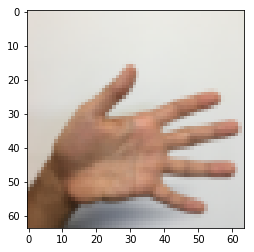

In [3]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train_orig[index]))

### 데이터 준비

- 픽셀 값을 [0,1] 사이로 조정
- target label을 one-hot encoding으로 변환 
- train set을 train/validation set으로 나눔

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = to_categorical(Y_train_orig)
Y_test = to_categorical(Y_test_orig)

X_val = X_train[:200]
partial_X_train = X_train[200:]
Y_val = Y_train[:200]
partial_Y_train = Y_train[200:]

In [5]:
X_val.shape

(200, 64, 64, 3)

In [6]:
partial_X_train.shape

(880, 64, 64, 3)

### Build a model
- 모형을 생성하고 complile하는 함수 만들기

In [7]:
def build_model(lr=0.001, nodes=[32,64,128,128]):
    K.clear_session()
    model = Sequential()
    model.add(layers.Conv2D(nodes[0], (3,3), strides = 1, padding = "same", input_shape = (64, 64, 3), activation="relu"))
    model.add(layers.MaxPool2D((8,8), padding = "same"))
    model.add(layers.Conv2D(nodes[1], (3,3), strides = 1, padding = "same", activation="relu"))
    model.add(layers.MaxPool2D((4,4), padding = "same"))
    model.add(layers.Conv2D(nodes[2], (3,3), strides = 1, padding = "same", activation="relu"))
    model.add(layers.MaxPool2D((4,4), padding = "same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(nodes[3], activation="relu"))
    model.add(layers.Dense(6, activation="softmax"))
    model.compile(optimizer = optimizers.adam(lr=lr), loss = "categorical_crossentropy",
                  metrics  = ['acc'])
    return model

### Image generator 생성


<font color=blue>
    TO DO: train data와 validation/test data를 증식하는 image generator를 만드시오. "cats and dogs"는 이미지가 subfolder에 분류되어 저장되어 있었으나 이 예제에서는 데이터가 np array 형태로 저장되어 있기 때문에 `ImageDataGenerator.flow_from_directory` 대신 `ImageDataGenerator.flow`를 사용해야 함.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

train_datagen = ImageDataGenerator(
#    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

# validation set은 augmentation을 하지 않고 있는 데이터 그대로를 사용
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    partial_X_train,
    partial_Y_train,
    batch_size=64)
validation_generator = test_datagen.flow(
    X_val,
    Y_val,
    batch_size=50
)

<font color=blue>
    
TO DO: `train_generator`가 생성하는 batch를 이해하기 위해 `next` 함수를 통해 `train_generator`로 하나의 batch를 생성하고 이를  `batch`이름으로 저장한 뒤 아래의 사항을 확인하시오.
- `batch`의 type은 무엇인가?
- `batch`의 length는 무엇인가?
- `batch`의 첫 번째 element는 어떤 shape을 가졌고 어떤 데이터가 포함되어 있는가?
- `batch`의 두 번째 element는 어떤 shape을 가졌고 어떤 데이터가 포함되어 있는가?
- `plt.imshow`를 사용하여 `batch`의 첫 번째 이미지를 프린트 하고 해당하는 label을 확인하시오.

In [9]:
batch=next(train_generator)

In [10]:
batch[0].shape

(64, 64, 64, 3)

In [22]:
batch[1].shape

(64, 6)

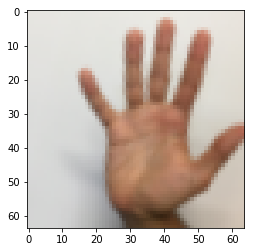

In [23]:
plt.imshow(batch[0][0])

<font color=blue>
    
TO DO: `train_datagen`이 증식하는 이미지를 아래의 절차를 따라 확인하시오. 
- X_train의 첫 번째 샘플을 `x`로 저장하고 이를 이미지로 프린트하시오. 
- `x`의 shape은 무엇인가? 
- `x`가 4D array가 되도록 변환하고 `train_datagen`을 통해 무작위로 증식되는 이미지를 5개 프린트해서 확인하시오. 증식되는 이미지가 학습데이터로 사용되기에 적절하다고 판단되는가? 그렇지 않다면 `train_datagen`을 수정한 뒤 다시 증식되는 이미지를 확인하시오.


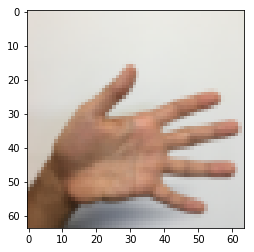

In [11]:
x=X_train[0]
plt.imshow(x)

In [12]:
x=np.expand_dims(x, axis=0)
x.shape

(1, 64, 64, 3)

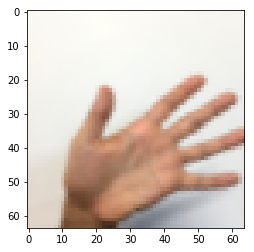

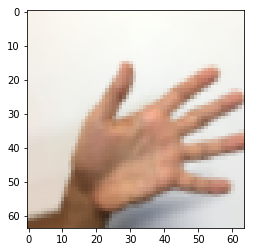

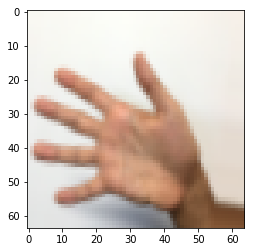

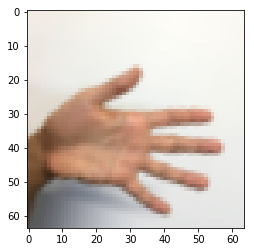

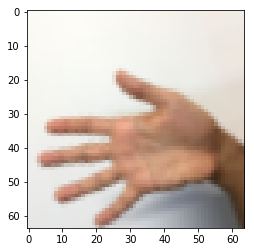

In [26]:
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break
plt.show()

## Model fitting

<font color=blue>
TO DO: `train_generator`와 `validation_generator`를 사용하여 모형을 학습하고 test set에 대해 accuracy를 확인하시오. 증식 전 보다 accuracy가 증가하였는가?

In [30]:
from keras.callbacks import TensorBoard
import time
now = time.strftime("%c")
model=build_model(lr=0.00059594)
callbacks_list = [
    TensorBoard(log_dir='./logs/sign/aug'+now),
    ModelCheckpoint(filepath='./models/sign_aug'+now+'.h5',monitor='val_loss',save_best_only=True)
]
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=4,
    callbacks=callbacks_list
)

Epoch 1/100
50/50 [==============================] - 3s 58ms/step - loss: 1.7916 - acc: 0.1873 - val_loss: 1.7770 - val_acc: 0.1850
Epoch 2/100
50/50 [==============================] - 2s 47ms/step - loss: 1.7018 - acc: 0.3236 - val_loss: 1.5314 - val_acc: 0.3650
Epoch 3/100
50/50 [==============================] - 3s 50ms/step - loss: 1.3950 - acc: 0.4290 - val_loss: 1.2933 - val_acc: 0.5050
Epoch 4/100
50/50 [==============================] - 3s 55ms/step - loss: 1.2583 - acc: 0.5139 - val_loss: 1.2092 - val_acc: 0.5250
Epoch 5/100
50/50 [==============================] - 3s 50ms/step - loss: 1.1135 - acc: 0.5971 - val_loss: 1.0277 - val_acc: 0.6450
Epoch 6/100
50/50 [==============================] - 3s 53ms/step - loss: 1.0425 - acc: 0.5972 - val_loss: 0.8293 - val_acc: 0.7100
Epoch 7/100
50/50 [==============================] - 3s 54ms/step - loss: 0.9178 - acc: 0.6673 - val_loss: 0.7858 - val_acc: 0.6850
Epoch 8/100
50/50 [==============================] - 3s 55ms/step - loss: 0.

In [33]:
from keras.models import load_model
final_model = load_model('./models/sign_aug'+now+'.h5')
final_model.evaluate(X_test, Y_test)

120/120 [==============================] - 0s 770us/step


[0.09764407090842724, 0.975]

### 나의 사진 테스트

<font color="blue">

TO DO: 
    본인의 손가락으로 숫자를 표현하는 사진을 찍어 jpg형태로 저장한 후 figures folder에 업로드하고 아래의 코드를 실행하여 사진을 모형에 입력가능한 형태로 변환하시오. 변환된 사진을 학습된 모형에 입력하여 분류 결과를 확인하시오. 

class: 3


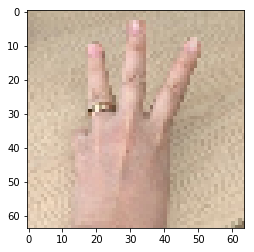

In [39]:
from keras.preprocessing import image 

img_path = 'figures/myhand3.jpg'
img = image.load_img(img_path, target_size=(64, 64))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=final_model.predict_classes(x)
print('class: %d'%(pred))

References
- https://www.coursera.org/specializations/deep-learning